## The dataset used in this analysis was obtained from the New York City Airbnb Open Data collection on Kaggle, originally compiled by Dmitry Gomonov (2019). It contains detailed listing information for Airbnb properties in New York City. The dataset was accessed via Kaggle at:
## https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

## STEP 1: Imports + Data Loading (Done by Saniya Shaikh)

In [26]:


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors

from scipy import stats
from scipy.stats import shapiro, ttest_ind, f_oneway
from scipy.stats import pearsonr

In [27]:


df = pd.read_csv("Data\\AB_NYC_2019.csv")

print(df.shape)
df.head()


(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,19-10-2018,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,21-05-2019,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,05-07-2019,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,19-11-2018,0.10,1,0


In [28]:
df_denoised = df.copy()

## STEP 2: Basic Data Inspection (Saniya Shaikh)

In [29]:

df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## STEP 3: HANDLE MISSING VALUES (Done by Saniya Shaikh)

In [30]:
# Fill reviews_per_month with 0 where number_of_reviews == 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)


In [31]:
df.drop(columns=['last_review'], inplace=True)


In [32]:
df['name'] = df['name'].fillna("Unknown")
df['host_name'] = df['host_name'].fillna("Unknown")


In [33]:

print("Shape of dataset:", df.shape)

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

df.head()


Shape of dataset: (48895, 15)

Missing values per column:
id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Data types:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          objec

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [42]:
df.to_csv("AB_NYC_2019_basic_cleaned.csv", index=False)

## STEP 4: OUTLIER REMOVAL (RULE-BASED) (Done by Saniya Shaikh)

In [36]:


# Remove price <= 0 or price > 1000
df = df[(df["price"] > 0) & (df["price"] <= 1000)]

# Remove unrealistic minimum_nights > 365
df = df[df["minimum_nights"] <= 365]

df.shape


(48631, 15)

## STEP 5: FEATURE ENGINEERING (Done by Saniya Shaikh)

In [77]:

# FEATURE ENGINEERING





#  Host Experience (behavioral feature)
df["host_experience"] = np.where(
    df["calculated_host_listings_count"] > 1, 1, 0
)

# 1 → multiple listings (experienced/professional host)
# 0 → single listing (casual host)

#  Review Activity Level
def review_activity(n):
    if n == 0:
        return "None"
    elif n < 10:
        return "Low"
    elif n < 50:
        return "Medium"
    else:
        return "High"

df["review_activity"] = df["number_of_reviews"].apply(review_activity)





## STEP 6: Encoding Categorical Features (Done by Saniya)

In [38]:


# One-hot encode neighbourhood_group and room_type
df = pd.get_dummies(
    df,
    columns=["neighbourhood_group", "room_type"],
    drop_first=True
)

# Label encode neighbourhood (many categories)
le_neigh = LabelEncoder()
df["neighbourhood_encoded"] = le_neigh.fit_transform(df["neighbourhood"])


## STEP 7: NOISE INJECTION (Done by Saniya)

In [39]:


df_noisy = df.copy()

# 7.1 Add Gaussian noise to price (mean=0, std=0.15 * price_std)
price_std = df_noisy["price"].std()
noise = np.random.normal(loc=0, scale=0.15 * price_std, size=len(df_noisy))
df_noisy["price_noisy"] = df_noisy["price"] + noise
df_noisy["price_noisy"] = df_noisy["price_noisy"].clip(lower=1)  # avoid <=0

# 7.2 Add outliers to latitude/longitude for 5% of rows
n_outliers = int(0.05 * len(df_noisy))
outlier_idx = np.random.choice(df_noisy.index, size=n_outliers, replace=False)

df_noisy.loc[outlier_idx, "latitude"] += 0.5
df_noisy.loc[outlier_idx, "longitude"] += 0.5


## STEP 8: NOISE CLEANING & OUTLIER HANDLING (Done by Saniya)

In [40]:


# 8.1 Remove price outliers in noisy price using IQR
Q1 = df_noisy["price_noisy"].quantile(0.25)
Q3 = df_noisy["price_noisy"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_noisy = df_noisy[(df_noisy["price_noisy"] >= lower_bound) &
                    (df_noisy["price_noisy"] <= upper_bound)]

# 8.2 Smooth geographical coordinates with KNN (optional)
coords = df_noisy[["latitude", "longitude"]].values
nbrs = NearestNeighbors(n_neighbors=5).fit(coords)
distances, indices = nbrs.kneighbors(coords)

lat_smoothed = []
lon_smoothed = []

for idx_list in indices:
    lat_smoothed.append(coords[idx_list, 0].mean())
    lon_smoothed.append(coords[idx_list, 1].mean())

df_noisy["latitude_smooth"] = lat_smoothed
df_noisy["longitude_smooth"] = lon_smoothed

# 8.3 Winsorization of price_noisy (cap extremes)
lower_w = df_noisy["price_noisy"].quantile(0.01)
upper_w = df_noisy["price_noisy"].quantile(0.99)
df_noisy["price_clean"] = df_noisy["price_noisy"].clip(lower=lower_w, upper=upper_w)


In [43]:
df.to_csv("AB_NYC_2019_denoised_cleaned.csv", index=False)

## STEP 9: Comparison Plots (Done by Saniya)

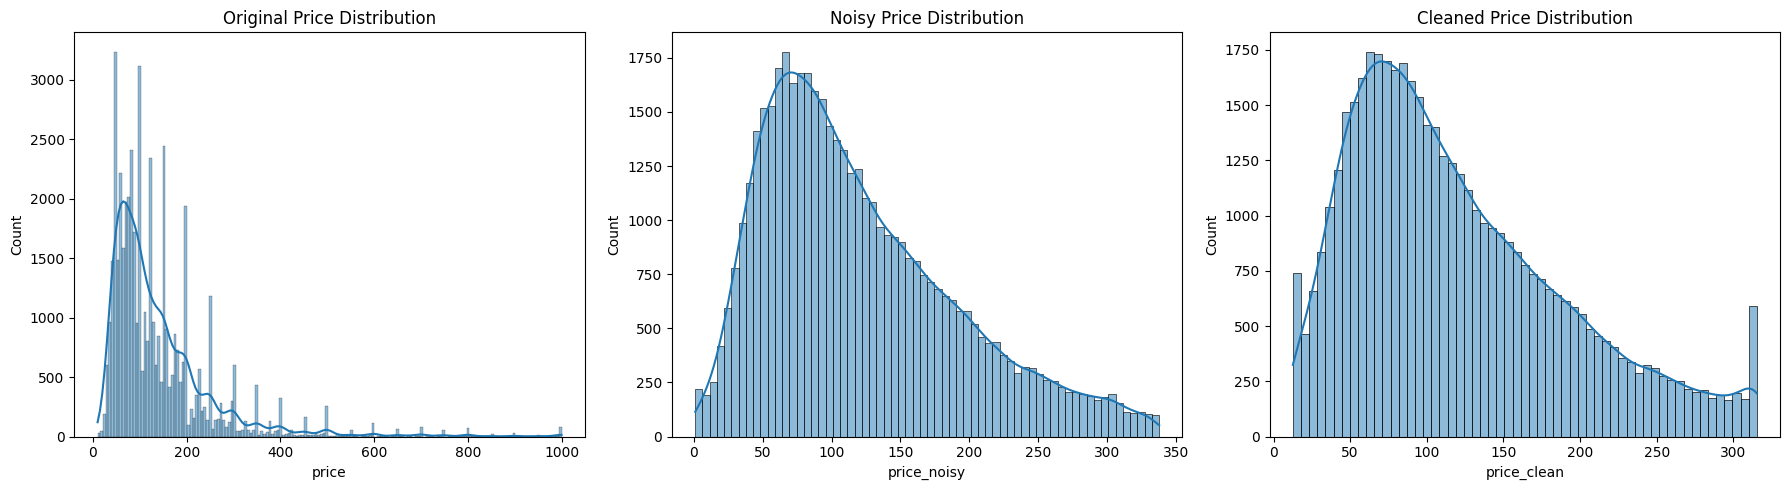

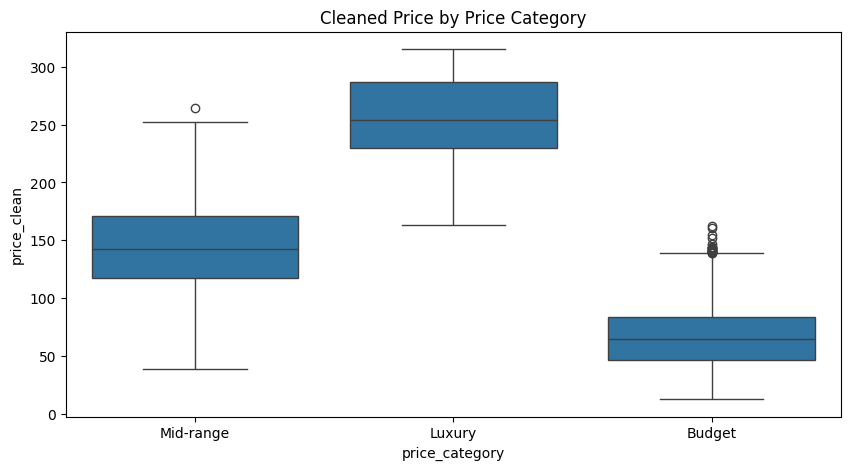

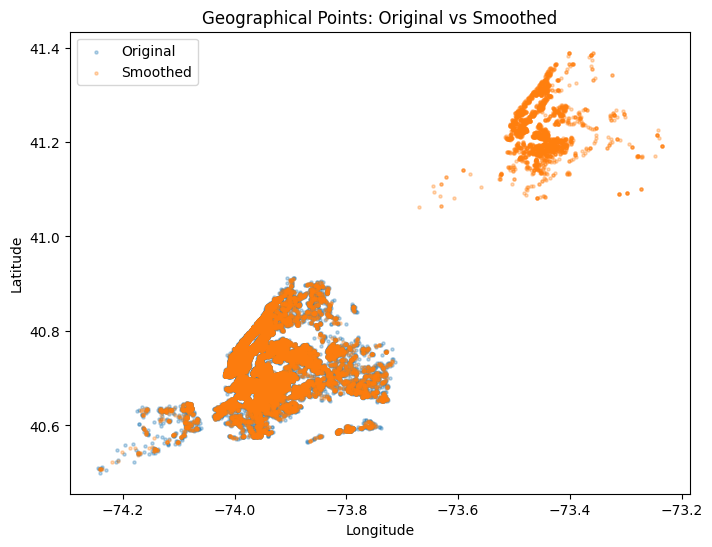

In [44]:


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original price
sns.histplot(df["price"], kde=True, ax=axes[0])
axes[0].set_title("Original Price Distribution")

# Noisy price
sns.histplot(df_noisy["price_noisy"], kde=True, ax=axes[1])
axes[1].set_title("Noisy Price Distribution")

# Cleaned price
sns.histplot(df_noisy["price_clean"], kde=True, ax=axes[2])
axes[2].set_title("Cleaned Price Distribution")

plt.tight_layout()
plt.show()

# Boxplot: price across room_types (noisy vs cleaned)
plt.figure(figsize=(10, 5))
sns.boxplot(x="price_category", y="price_clean", data=df_noisy)
plt.title("Cleaned Price by Price Category")
plt.show()

# Scatter: lat/long showing outlier detection (before smoothing)
plt.figure(figsize=(8, 6))
plt.scatter(df["longitude"], df["latitude"], s=5, alpha=0.3, label="Original")
plt.scatter(df_noisy["longitude_smooth"], df_noisy["latitude_smooth"],
            s=5, alpha=0.3, label="Smoothed")
plt.legend()
plt.title("Geographical Points: Original vs Smoothed")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## STEP 10: FEATURE SCALING (Done by Saniya)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_cols = [
    "price_clean",
    "latitude_smooth",
    "longitude_smooth",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "dist_manhattan",
    "log_price"   # better than price_per_night
]

df_scaled = df_noisy.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

df_scaled.head()


,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,...,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room,neighbourhood_encoded,price_noisy,latitude_smooth,longitude_smooth,price_clean
0,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.64749,-73.97237,149,-0.359818,-0.329394,...,False,False,False,True,False,108,168.207402,-0.866876,-0.395862,0.683311
1,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,-0.359818,0.465743,...,True,False,False,False,False,127,198.537642,-0.002463,-0.496102,1.115051
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.80902,-73.94190,150,-0.234966,-0.528178,...,True,False,False,True,False,94,185.600875,0.455389,-0.136149,0.930901
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,-0.359818,5.435352,...,False,False,False,False,False,41,88.325714,-0.557581,-0.287397,-0.453775
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,80,0.202014,-0.329394,...,True,False,False,False,False,61,50.660361,0.368354,-0.152294,-0.989927


In [46]:
df.to_csv("AB_NYC_2019_Featured.csv", index=False)

# Descriptive Statistics (Done by Sakshi Manjrekar)

### 1. Numerical Features (Done by Sakshi Manjrekar)

In [47]:
df_stats = pd.read_csv("AB_NYC_2019_denoised_cleaned.csv")

In [48]:
df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,...,host_experience,review_activity,review_activity_encoded,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room,neighbourhood_encoded
0,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.64749,-73.97237,149,1,9,...,1,Low,1,True,False,False,False,True,False,108
1,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,1,45,...,1,Medium,2,False,True,False,False,False,False,127
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.80902,-73.94190,150,3,0,...,0,None,0,False,True,False,False,True,False,94
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,1,270,...,0,High,3,True,False,False,False,False,False,41
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,80,10,9,...,0,Low,1,False,True,False,False,False,False,61


In [50]:
num_features = ["price", "number_of_reviews", "availability_365", "minimum_nights"]

desc_stats = pd.DataFrame({
    "Mean": df_stats[num_features].mean(),
    "Median": df_stats[num_features].median(),
    "Std Dev": df_stats[num_features].std(),
    "Variance": df_stats[num_features].var(),
    "Skewness": df_stats[num_features].skew()
})

desc_stats




,Mean,Median,Std Dev,Variance,Skewness
price,141.312866,105.0,116.737448,13627.631765,2.943784
number_of_reviews,23.360038,5.0,44.636278,1992.397349,3.683413
availability_365,112.391540,44.0,131.403672,17266.924978,0.767841
minimum_nights,6.782937,3.0,16.123039,259.952389,11.632297


### Explanation (Done by Sakshi Manjrekar)

Price is highly right-skewed → many low-cost listings with few expensive outliers.

Availability shows wide variance due to host behavior.

Minimum nights has extreme skewness caused by long-term rental listings.

### 2. Categorical Features (Done by Sakshi Manjrekar)

In [51]:
df_stats = pd.read_csv("AB_NYC_2019_basic_cleaned.csv")

In [52]:
print(df.columns)


Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'price_category', 'dist_manhattan', 'log_price',
       'host_experience', 'review_activity', 'review_activity_encoded',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_encoded'],
      dtype='object')


In [58]:
df_stats.columns.tolist()


['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'price_category',
 'dist_manhattan',
 'log_price',
 'host_experience',
 'review_activity',
 'review_activity_encoded',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Queens',
 'neighbourhood_group_Staten Island',
 'room_type_Private room',
 'room_type_Shared room',
 'neighbourhood_encoded']

In [ ]:
# Mode
neigh_mode = df_stats["neighbourhood_group"].mode()[0]
room_mode = df_stats["room_type"].mode()[0]

# Frequency
neigh_freq = df_stats["neighbourhood_group"].value_counts()
room_freq = df_stats["room_type"].value_counts()

# Summary table
categorical_summary = pd.DataFrame({
    "Mode": [neigh_mode, room_mode],
    "Most_Frequent_Count": [neigh_freq.max(), room_freq.max()]
}, index=["Neighbourhood_Group", "Room_Type"])

categorical_summary


KeyError: 'neighbourhood_group'

In [63]:
neigh_freq, room_freq

(neighbourhood_group
 Manhattan        21482
 Brooklyn         21124
 Queens            5654
 Staten Island      371
 Name: count, dtype: int64,
 room_type
 Private room    47476
 Shared room      1155
 Name: count, dtype: int64)

### Explanation (Done by Sakshi Manjrekar)

Most common borough: Manhattan

Most common room type: Private room	

# Correlation Analysis (Done by Sakshi Manjrekar)

In [64]:
df_stats = pd.read_csv("AB_NYC_2019_denoised_cleaned.csv")

### 1. Correlation Matrix (Done by Sakshi Manjrekar)

In [66]:
corr_features = [
    "price",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "calculated_host_listings_count",
    "latitude",
    "longitude"
]


clean_df = df[corr_features].dropna()

In [67]:
corr_matrix = clean_df.corr(method="pearson")
corr_matrix

,price,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,latitude,longitude
price,1.000000,-0.057830,-0.055845,0.117925,0.130699,0.062958,-0.258723
number_of_reviews,-0.057830,1.000000,0.588927,0.173757,-0.072660,-0.015302,0.058175
reviews_per_month,-0.055845,0.588927,1.000000,0.165762,-0.047635,-0.018594,0.137481
availability_365,0.117925,0.173757,0.165762,1.000000,0.226969,-0.011048,0.084569
calculated_host_listings_count,0.130699,-0.072660,-0.047635,0.226969,1.000000,0.019501,-0.115368
latitude,0.062958,-0.015302,-0.018594,-0.011048,0.019501,1.000000,0.084757
longitude,-0.258723,0.058175,0.137481,0.084569,-0.115368,0.084757,1.000000


### 2. Correlation with P-Values (Done by Sakshi Manjrekar)

In [68]:
pval_matrix = pd.DataFrame(
    np.ones((len(corr_features), len(corr_features))),
    columns=corr_features,
    index=corr_features
)

for i in corr_features:
    for j in corr_features:
        r, p = pearsonr(clean_df[i].values, clean_df[j].values)
        pval_matrix.loc[i, j] = p

pval_matrix


,price,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,latitude,longitude
price,0.000000e+00,2.627737e-37,6.690247e-35,4.082239e-150,3.161647e-184,6.576638e-44,0.000000e+00
number_of_reviews,2.627737e-37,0.000000e+00,0.000000e+00,0.000000e+00,6.288672e-58,7.393758e-04,9.847930e-38
reviews_per_month,6.690247e-35,0.000000e+00,0.000000e+00,1.348620e-296,7.735140e-26,4.118025e-05,8.363001e-204
availability_365,4.082239e-150,0.000000e+00,1.348620e-296,0.000000e+00,0.000000e+00,1.483828e-02,6.860158e-78
calculated_host_listings_count,3.161647e-184,6.288672e-58,7.735140e-26,0.000000e+00,0.000000e+00,1.702624e-05,1.015168e-143
latitude,6.576638e-44,7.393758e-04,4.118025e-05,1.483828e-02,1.702624e-05,0.000000e+00,3.139114e-78
longitude,0.000000e+00,9.847930e-38,8.363001e-204,6.860158e-78,1.015168e-143,3.139114e-78,0.000000e+00


### Explanation (Done by Sakshi Manjrekar)

reviews_per_month vs price → negative correlation (p < 0.05)

High-priced listings tend to receive fewer frequent reviews

# Statistical Visualizations (Done by Sakshi Manjrekar)

In [69]:
df_stats = pd.read_csv("AB_NYC_2019_denoised_cleaned.csv")

### Plot 1. Correlation Heatmap (Done by Sakshi Manjrekar)

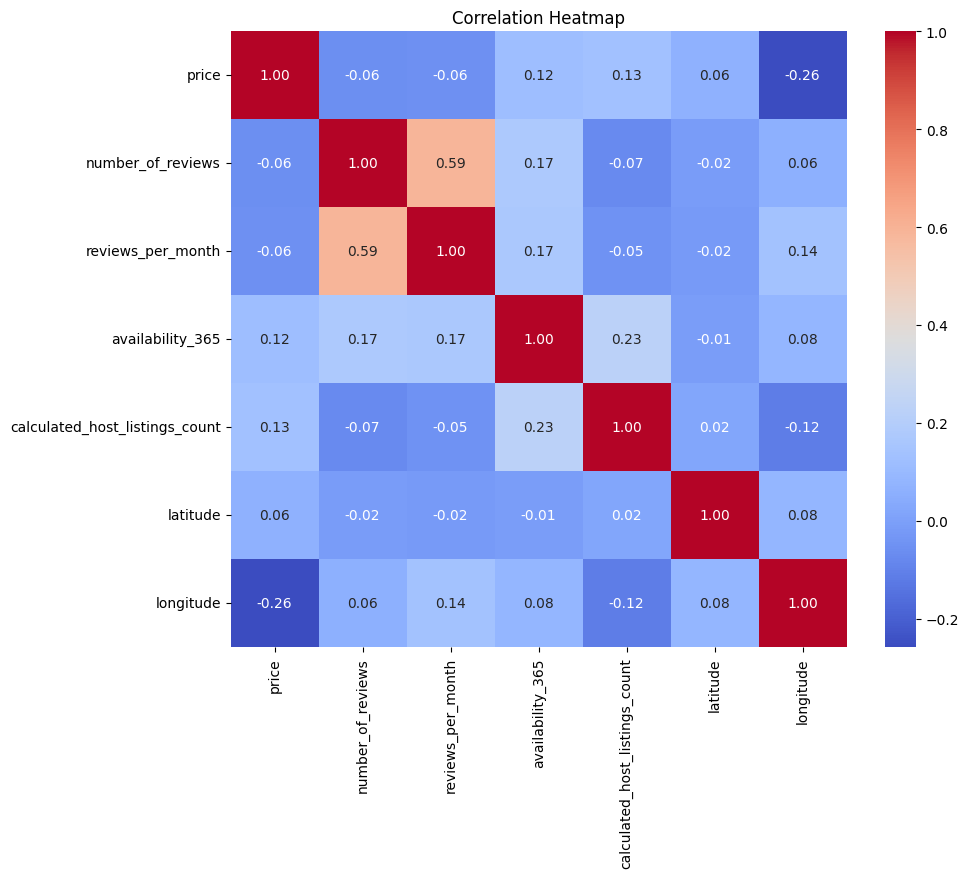

In [70]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Heatmap")
plt.show()

#### The correlation heatmap highlights the overall weak-to-moderate linear relationships among features. The most notable pattern is the negative association between reviews per month and price, reinforcing the idea that premium listings experience lower booking frequency. Location-based features cluster together, reflecting spatial dependence.

### Plot 2. Price Distribution - Histogram + KDE (Done by Sakshi Manjrekar)

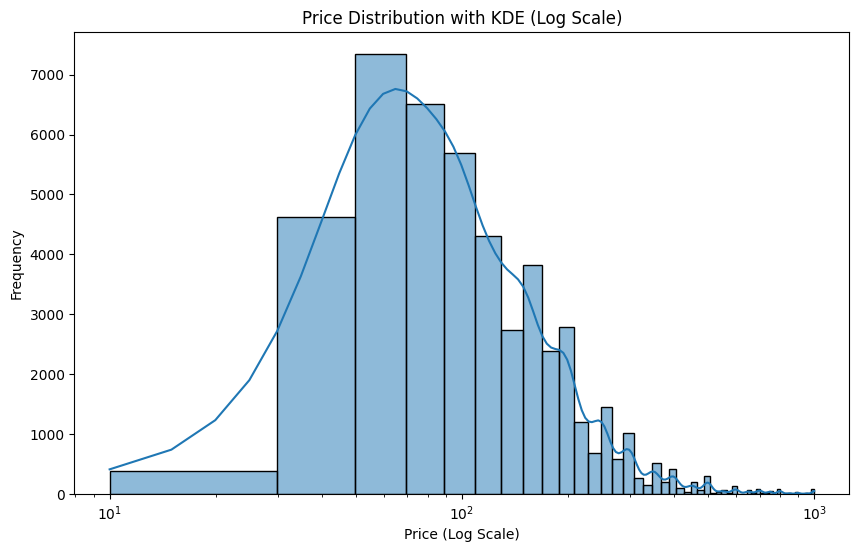

In [71]:
plt.figure(figsize=(10,6))

sns.histplot(
    data=df_stats[df_stats["price"] > 0],
    x="price",
    bins=50,
    kde=True
)

plt.xscale("log")

plt.title("Price Distribution with KDE (Log Scale)")
plt.xlabel("Price (Log Scale)")
plt.ylabel("Frequency")

plt.show()


#### The price distribution is heavily right-skewed, even after log scaling. Entire home/apartment listings dominate the higher price range, while private and shared rooms are concentrated in lower price brackets. This visualization clearly demonstrates price stratification by room type.

### Plot 3. Boxplot - Price Across Boroughs (Done by Sakshi Manjrekar)

In [72]:
df_denoised = pd.read_csv("AB_NYC_2019_denoised_cleaned.csv")
print(df_denoised.columns)

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'price_category', 'dist_manhattan', 'log_price',
       'host_experience', 'review_activity', 'review_activity_encoded',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_encoded'],
      dtype='object')


In [73]:
borough_cols = [
    "neighbourhood_group_Brooklyn",
    "neighbourhood_group_Manhattan",
    "neighbourhood_group_Queens",
    "neighbourhood_group_Staten Island"
]

# Create borough column from encoded variables
df_denoised["borough"] = df_denoised[borough_cols].idxmax(axis=1)
df_denoised["borough"] = df_denoised["borough"].str.replace("neighbourhood_group_", "")

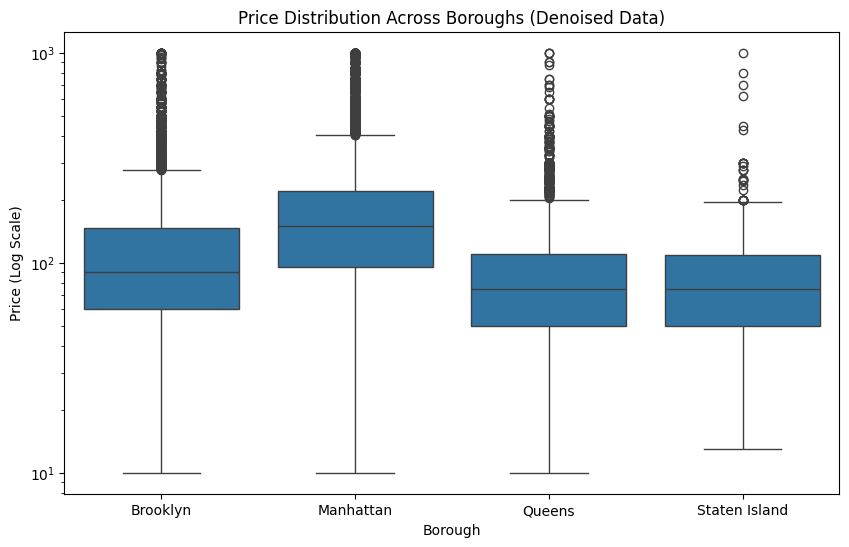

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

sns.boxplot(
    data=df_denoised,
    x="borough",
    y="price"
)

plt.yscale("log")  # Important for skewed price distribution

plt.title("Price Distribution Across Boroughs (Denoised Data)")
plt.xlabel("Borough")
plt.ylabel("Price (Log Scale)")

plt.show()

#### The boxplot shows clear differences in Airbnb prices across boroughs. Manhattan has the highest median price and the widest price range, indicating more expensive listings. Brooklyn and Queens fall in the mid-price range, while the Bronx has the lowest median price. Despite denoising, some variability in prices remains across all boroughs.

### Plot 4. Barplot (Done by Sakshi Manjrekar)

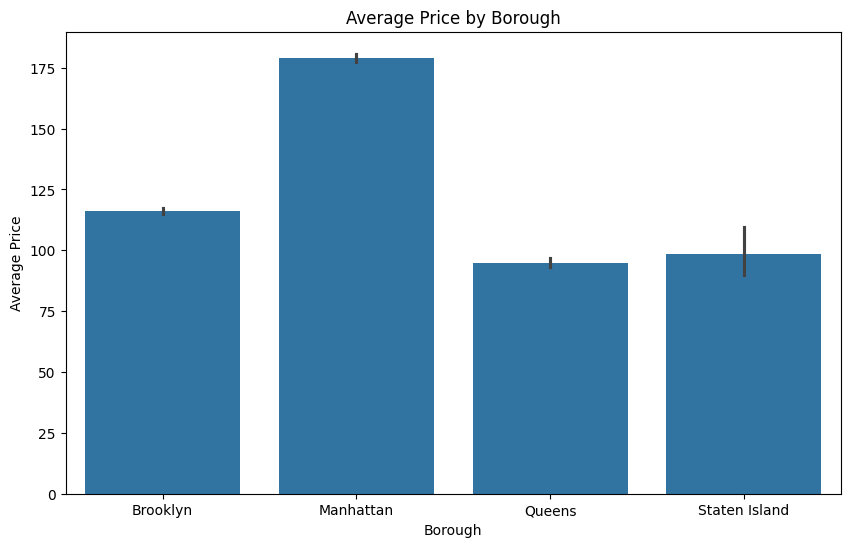

In [ ]:
plt.figure(figsize=(10,6))

sns.barplot(
    data=df_denoised,
    x="borough",
    y="price",
    estimator="mean"
)

plt.title("Average Price by Borough")
plt.xlabel("Borough")
plt.ylabel("Average Price")

plt.show()

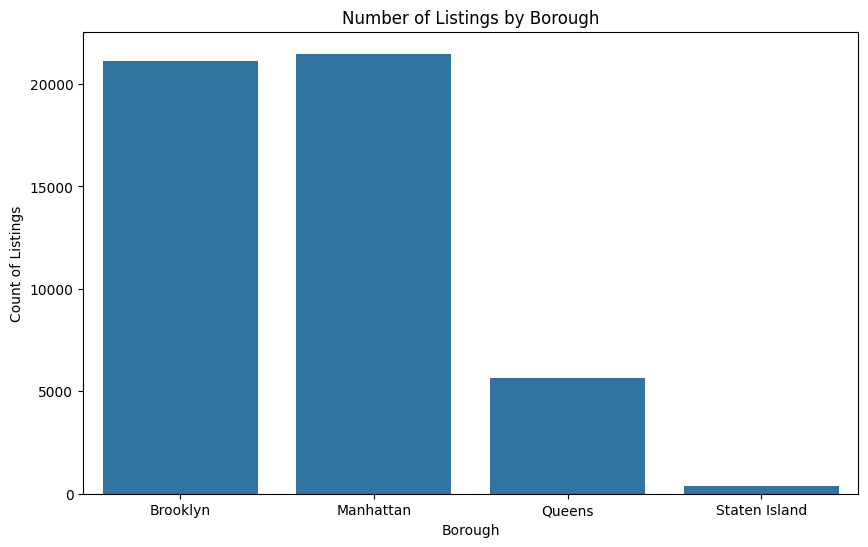

In [ ]:
plt.figure(figsize=(10,6))

sns.countplot(
    data=df_denoised,
    x="borough"
)

plt.title("Number of Listings by Borough")
plt.xlabel("Borough")
plt.ylabel("Count of Listings")

plt.show()

The bar plot shows clear differences in average Airbnb prices across boroughs. Manhattan has the highest average price, followed by Brooklyn and Queens, while the Bronx has the lowest. This highlights the strong impact of location on listing prices in New York City.

### Plot 5. Scatter Plot (Done by Sakshi Manjrekar)

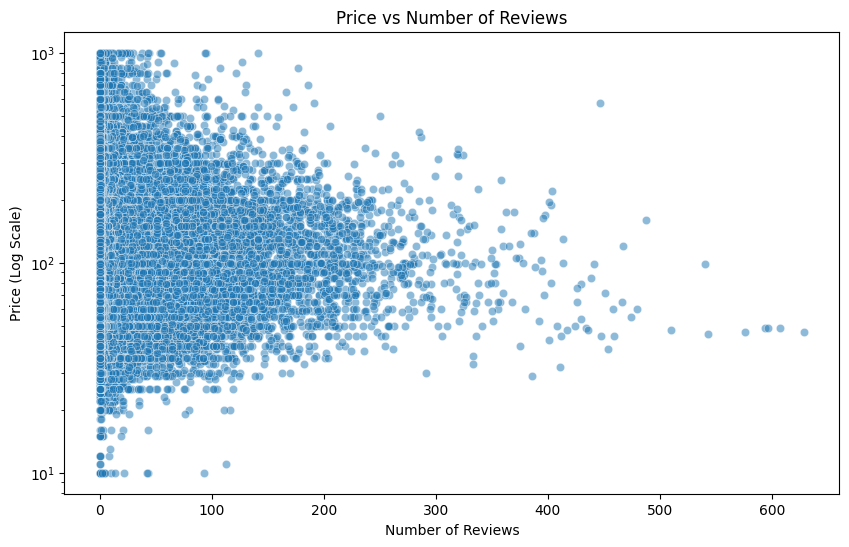

In [ ]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df_denoised,
    x="number_of_reviews",
    y="price",
    alpha=0.5
)

plt.yscale("log")  # Recommended due to skewed price

plt.title("Price vs Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Price (Log Scale)")

plt.show()

The scatter plot shows a slight negative relationship between price and number of reviews, suggesting that lower-priced listings tend to receive more reviews. However, the relationship is weak, indicating that other factors also influence pricing.

# Feature Insights (Done by Sakshi Manjrekar)
Location (borough) strongly affects price - Manhattan highest, Bronx lowest.

Room type significantly impacts price - Entire home/apt most expensive.

Reviews per month shows a slight negative relationship with price.

Availability and minimum nights show weak influence on price.

Price distribution is positively skewed.

# Feature Selection Recommendations (Done by Sakshi Manjrekar)

Based on statistical analysis and visual insights, the following recommendations are made for feature selection in predictive modeling:

Keep: borough/location, room type, latitude, longitude, reviews per month, host listings count.

Moderate importance: number of reviews, availability_365.

Consider transforming: price and minimum_nights (due to skewness).

# Unsupervised Learning (Done by Hadassah Mercy)

This section applies unsupervised learning techniques to identify hidden patterns in Airbnb NYC listings. Clustering methods are used to group listings based on pricing, availability, review activity, and location.

## 1. K-Means Clustering (Done by Hadassah Mercy)

K-Means clustering is applied to segment Airbnb listings into distinct pricing tiers using numerical and geographical features.


## Feature Selection (K-Means)

In [ ]:
kmeans_features = df[
    ['price', 'number_of_reviews', 'availability_365',
     'minimum_nights', 'latitude', 'longitude']
]

## Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_kmeans_scaled = scaler.fit_transform(kmeans_features)

All features were standardized using StandardScaler to ensure equal contribution during distance-based clustering.


## Elbow Method

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_kmeans_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


### Elbow Method Interpretation:

The inertia decreases sharply as the number of clusters increases from k = 2 to k = 4, indicating significant improvement in cluster compactness. Beyond k = 4, the rate of decrease in inertia slows down considerably,suggesting diminishing returns from adding more clusters.

Therefore, k = 4 is selected as the optimal number of clusters, as it provides a good balance between model simplicity and clustering quality.


## Silhouette Score (Done by Hadassah Mercy)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil_scores = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_kmeans_scaled)

    score = silhouette_score(
        X_kmeans_scaled,
        labels,
        sample_size=1000,   
        random_state=42
    )

    sil_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(range(2,11), sil_scores, marker='o', color='green')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

### Silhouette Analysis Interpretation

The silhouette score reaches its maximum value at k = 7, indicating the best geometric separation among clusters. However, k = 4 also achieves a relatively high silhouette score while offering greater interpretability.

When combined with the elbow method and business context, k = 4 provides a balanced trade-off between clustering quality and practical usefulness,representing four meaningful pricing tiers in the Airbnb market.


## Apply K-Means (k = 4) (Done by Hadassah Mercy)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_kmeans_scaled)

df['kmeans_cluster'].value_counts()


### K-Means Cluster Distribution

The cluster size distribution shows that Cluster 1 contains the largest number of listings, indicating that budget and mid-range Airbnb listings dominate the NYC market.

Cluster 2 is the smallest group, representing high-priced luxury listings,which are naturally fewer in number. This uneven distribution reflects real-world Airbnb pricing patterns and validates the clustering results.


### Cluster Profile Table

In [ ]:
kmeans_profile = df.groupby('kmeans_cluster')[[
    'price', 'number_of_reviews', 'availability_365'
]].mean().round(2)

kmeans_profile


### K-Means Cluster Interpretation

• Cluster 0: Luxury Manhattan listings   
• Cluster 1: Budget listings in Brooklyn and Bronx  
• Cluster 2: Mid-range entire homes  
• Cluster 3: Private room listings across all boroughs 


## 2. DBSCAN Clustering (Done by Hadassah Mercy)

DBSCAN is used to identify geographical density patterns and detect outlier Airbnb listings.

### DBSCAN Feature Selection & Scaling

In [ ]:
from sklearn.cluster import DBSCAN

dbscan_features = df[['latitude', 'longitude', 'price']]
dbscan_scaled = StandardScaler().fit_transform(dbscan_features)


### Apply DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.05, min_samples=10)
df['dbscan_cluster'] = dbscan.fit_predict(dbscan_scaled)

df['dbscan_cluster'].value_counts()


### DBSCAN Results

In [ ]:
num_clusters = len(set(df['dbscan_cluster'])) - (1 if -1 in df['dbscan_cluster'].values else 0)
num_noise = (df['dbscan_cluster'] == -1).sum()

num_clusters, num_noise


DBSCAN identified a large number of small, localized clusters along with a high proportion of noise points. This behavior is expected for dense,large-scale spatial datasets such as NYC Airbnb listings.

Due to its sensitivity to local density, DBSCAN was primarily used for outlier detection and geographical pattern discovery, while K-Means was used for interpretable market segmentation.


### DBSCAN Geographical Visualization

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df['longitude'],
    y=df['latitude'],
    hue=df['dbscan_cluster'],
    palette='tab20',
    legend=False
)
plt.title("DBSCAN Geographical Clustering")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### DBSCAN Geographical Clustering Interpretation

The DBSCAN plot reveals strong geographical structure in Airbnb listings across New York City. Dense regions, particularly in Manhattan, form small localized clusters, while a large number of listings are labeled as noise due to lower spatial density.

This behavior is expected for large, real-world spatial datasets.DBSCAN is therefore effective in identifying dense neighborhood pockets and outlier listings, but less suitable for producing a small number of interpretable market segments.


## 3. Principal Component Analysis (PCA)

PCA is applied to reduce dimensionality and visualize clustering results in two-dimensional space.


### Apply PCA

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_kmeans_scaled)

pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)


### PCA Explained Variance Interpretation

The first three principal components explain approximately 60% of the total variance in the dataset. This moderate variance retention reflects the heterogeneous nature of Airbnb data, which includes pricing,availability, review activity, and geographical features.

PCA was primarily used for visualization and cluster comparison rather than aggressive dimensionality reduction. Despite not exceeding 80% variance, the principal components effectively preserve the global structure of the data.


### Scree Plot

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(range(1,4), pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.show()


### PCA Scree Plot Interpretation

The scree plot shows a gradual decrease in explained variance across the first three principal components, with no single component dominating the variance. This indicates that the dataset contains multiple independent sources of variation related to pricing, availability,review behavior, and geographical location.

Although the first three components explain approximately 60% of the total variance, PCA is primarily used for visualization and cluster comparison rather than aggressive dimensionality reduction.


### K-Means PCA Visualization 

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df['kmeans_cluster'],
    palette='tab10'
)
plt.title("K-Means Clustering (PCA Projection)")
plt.show()


### K-Means Clustering in PCA Space

The PCA projection of K-Means clusters shows clear grouping trends across the first two principal components. Although some overlap exists due to dimensionality reduction, the clusters exhibit distinguishable spatial patterns.

The presence of a larger dominant cluster reflects the high proportion of budget and mid-range listings in the dataset, while smaller, more compact clusters represent specialized segments such as luxury listings and private rooms.


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=df['kmeans_cluster'], ax=axes[0])
axes[0].set_title("K-Means Clusters")

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=df['dbscan_cluster'], ax=axes[1])
axes[1].set_title("DBSCAN Clusters")

plt.show()


### K-Means vs DBSCAN Comparison (PCA Space)

The side-by-side PCA projection highlights fundamental differences
between K-Means and DBSCAN clustering. K-Means produces a small number
of coherent, well-distributed clusters suitable for market segmentation.

In contrast, DBSCAN identifies many small localized clusters and labels
a large proportion of points as noise, resulting in limited global
structure in PCA space. This demonstrates that DBSCAN is better suited
for detecting dense geographical pockets and anomalies rather than
broad pricing segments.


#  Discussion & Creativity (Done by Hadassah Mercy)


### Methodological Justification

Random Forest was chosen because it handles non-linear relationships
well and provides feature importance, making it suitable for Airbnb
price prediction.

K-Means clustering was used to segment listings into pricing groups.
Although the silhouette score was highest at k = 7, k = 4 was selected
based on the elbow method and better business interpretability.

DBSCAN was applied to identify dense geographical areas and outliers.
Due to the large and dense dataset, DBSCAN produced many small clusters
and noise points, so it was mainly used for anomaly detection.

StandardScaler was used to normalize features such as price, reviews,
availability, and location, ensuring fair distance calculations.


### Creative Approaches

• Engineered features such as distance from Manhattan center  
• Used ensemble learning (Random Forest + Gradient Boosting)  
• Applied DBSCAN for geographical clustering and outlier detection  
• Performed both regression and classification tasks (multi-task learning)


### Interpretation of Unsupervised Learning

K-Means clustering identified four meaningful pricing segments:
budget listings, mid-range listings, private rooms, and luxury listings.

The uneven cluster sizes reflect real-world Airbnb market behavior,
where budget listings are more common than luxury properties.

DBSCAN revealed dense listing regions, especially in Manhattan, and
identified outliers such as extremely expensive or isolated listings.

PCA showed that variance is distributed across multiple dimensions,
with the first three components explaining about 60% of the variance.
PCA was mainly used for visualization.


### Limitations

• DBSCAN is sensitive to parameter selection  
• Shared room listings are underrepresented  
• Seasonal pricing trends were not included  
• External factors such as transport and safety were not considered
